In [1]:
%%capture
!pip3 install tensorflow==2.0.0-beta1

In [2]:
import tensorflow as tf
import numpy as np
import gym
import datetime
from tqdm import tqdm_notebook
import logging
import random
import itertools
from utils import go_utils, rl_utils
import matplotlib.pyplot as plt
import collections
from functools import reduce

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)

# Hyperparameters

In [4]:
BOARD_SIZE = 7

In [5]:
ITERATIONS = 256
EPISODES_PER_ITERATION = 128
MAX_STEPS = 2 * BOARD_SIZE**2
BATCH_SIZE = 512

In [6]:
ACTOR_LEARNING_RATE = 5e-4
ACTOR_BETA_1 = 0.9
CRITIC_LEARNING_RATE = 1e-3
CRITIC_BETA_1 = 0.9

In [7]:
BASELINE_DIR = 'model_baselines/'
LEVEL_PATHS = [None] + [BASELINE_DIR + filename for filename in ['novice.h5']]
STARTING_OPPONENT_PATH = LEVEL_PATHS[1]

In [8]:
SAVE_EVERY_ITERATION = True
LOAD_SAVED_MODELS = True

# Go Environment
Train on a small board with heuristic reward for fast training and efficient debugging

In [9]:
go_env = gym.make('gym_go:go-v0', size=BOARD_SIZE, reward_method='real')

# Machine Learning Models

In [10]:
ACTOR_PATH = 'tmp/actor.h5'
CRITIC_PATH = 'tmp/critic.h5'

In [11]:
from tensorflow.keras import layers

In [12]:
def make_actor_critic(mode):
    inputs = layers.Input(shape=(BOARD_SIZE, BOARD_SIZE, 4), name="board")
    valid_inputs = layers.Input(shape=(BOARD_SIZE**2 + 1,), name="valid_moves")
    invalid_values = layers.Input(shape=(BOARD_SIZE**2 + 1,), name="invalid_values")
    
    x = layers.Flatten()(inputs)
    
    x = layers.Dense(512)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(1024)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    x = layers.Dense(256)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    
    if mode == 'actor':
        move_probs = layers.Dense(128)(x)
        move_probs = layers.BatchNormalization()(move_probs)
        move_probs = layers.ReLU()(move_probs)
        move_probs = layers.Dense(50)(move_probs)
        move_probs = layers.Add()([move_probs, invalid_values])
        move_probs = layers.Softmax(name="move_probs")(move_probs)
        out = move_probs
    else:
        move_vals = layers.Dense(128)(x)
        move_vals = layers.BatchNormalization()(move_vals)
        move_vals = layers.ReLU()(move_vals)
        move_vals = layers.Dense(50, activation="sigmoid")(move_vals)
        move_vals = layers.Multiply(name="move_vals")([move_vals, valid_inputs])
        out = move_vals

    model = tf.keras.Model(inputs=[inputs, valid_inputs, invalid_values], 
                           outputs=out, name=mode)
    return model

In [13]:
actor = make_actor_critic('actor')

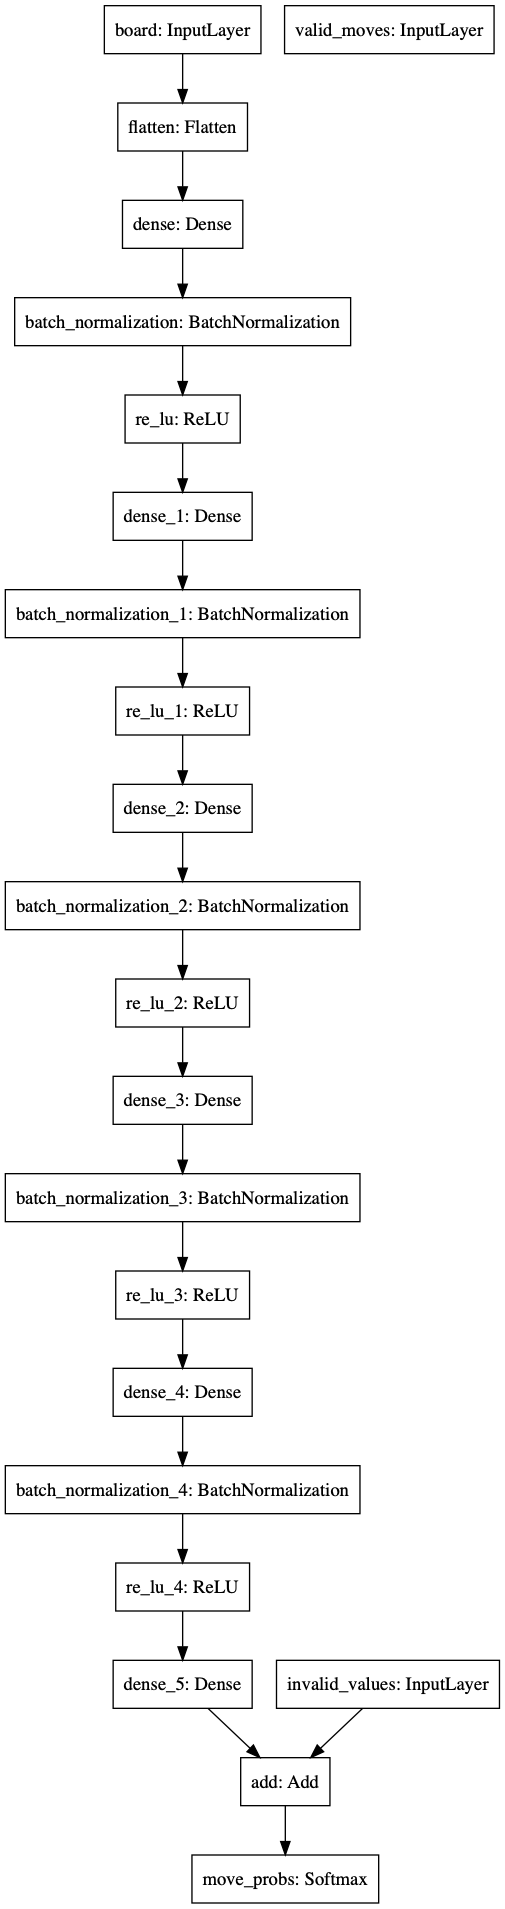

In [14]:
tf.keras.utils.plot_model(actor)

In [15]:
actor.summary()

Model: "actor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          100864      flatten[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512)          2048        dense[0][0]                      
______________________________________________________________________________________________

In [16]:
critic = make_actor_critic('critic')

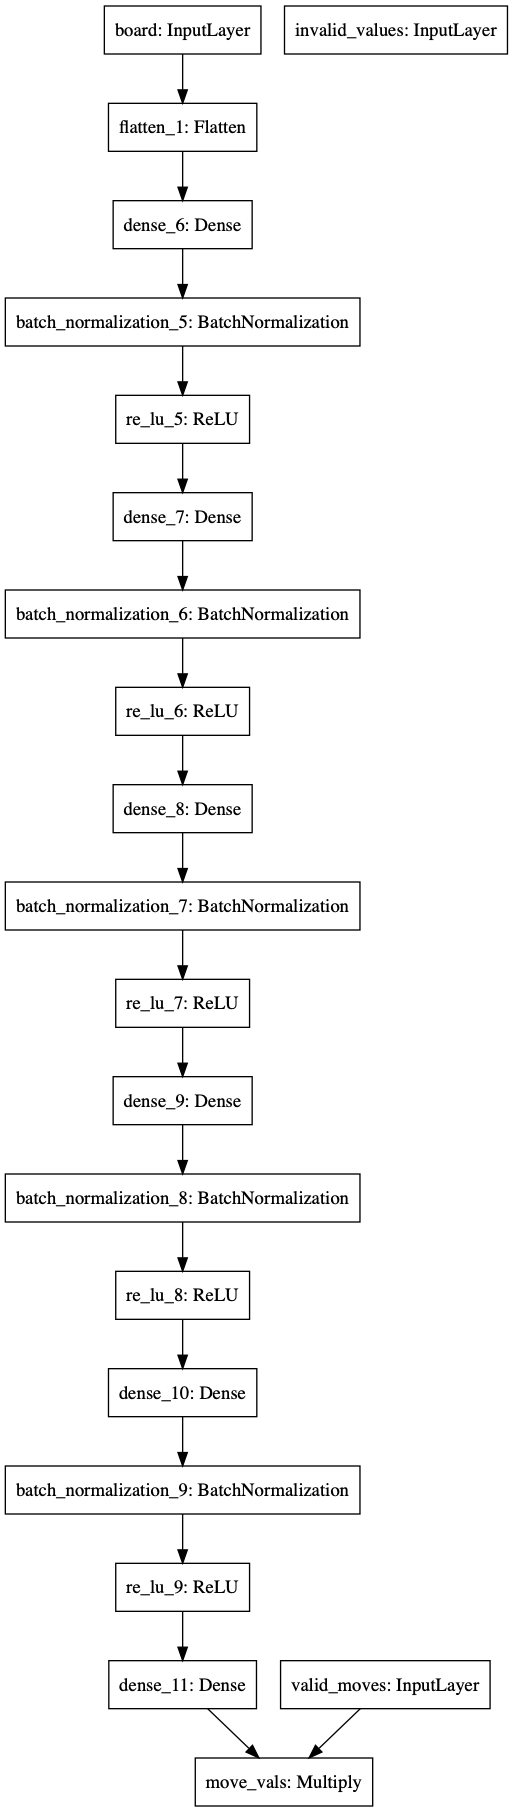

In [17]:
tf.keras.utils.plot_model(critic)

In [18]:
critic.summary()

Model: "critic"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
board (InputLayer)              [(None, 7, 7, 4)]    0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 196)          0           board[0][0]                      
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 512)          100864      flatten_1[0][0]                  
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 512)          2048        dense_6[0][0]                    
_____________________________________________________________________________________________

In [19]:
opponent = tf.keras.models.clone_model(actor)

In [20]:
if LOAD_SAVED_MODELS:
    actor.load_weights(ACTOR_PATH)
    critic.load_weights(CRITIC_PATH)
    opponent.load_weights(STARTING_OPPONENT_PATH)
    logging.info("Loaded models")

I0826 16:08:27.594923 4623640000 <ipython-input-20-c39ffcbd9d5e>:5] Loaded models


### Initialization of models 

In [21]:
mem = []
state = go_env.reset()
first_action = (2,5)
first_action_1d = go_utils.action_2d_to_1d(first_action, BOARD_SIZE)
second_action = (5,2)
first_state, reward, done, info = go_env.step(first_action)
second_state, reward, done, info = go_env.step(second_action)
rl_utils.add_to_replay_mem(mem, state, first_action_1d, second_state, reward, done)

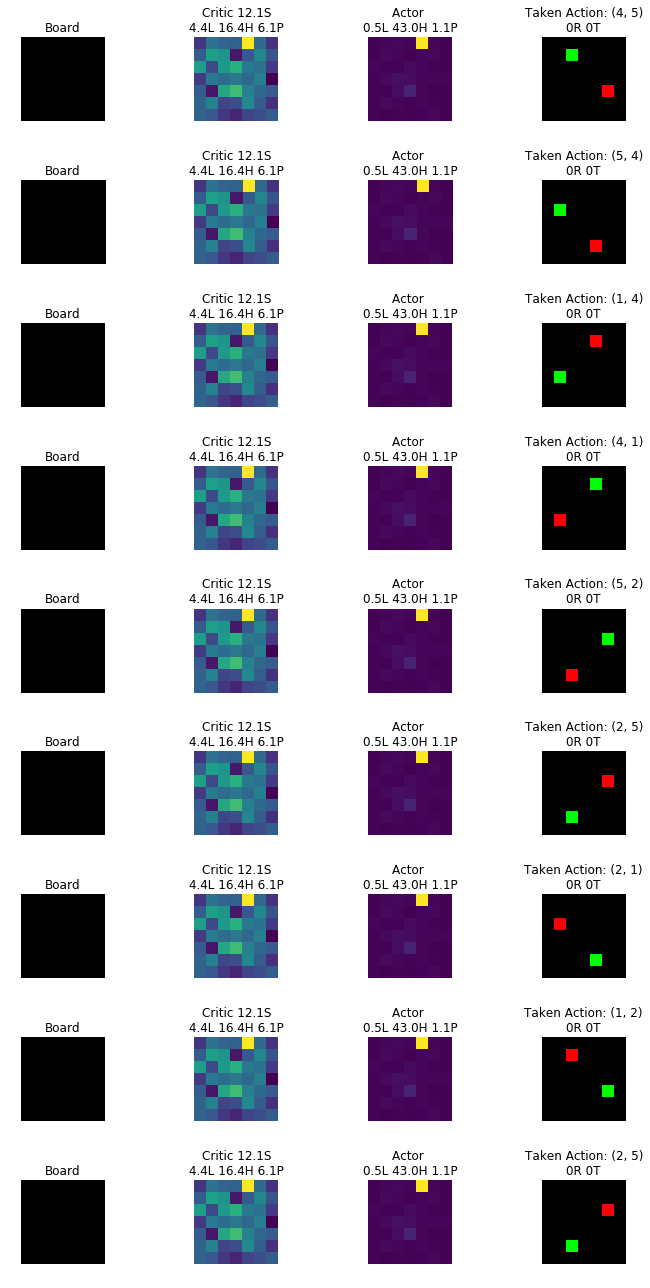

In [22]:
plt.show(rl_utils.sample_heatmaps(actor, critic, mem, num_samples=8))

# Training Setup

### Metrics and Tensorboard

In [23]:
!rm -rf ./logs/

Metrics

In [24]:
metrics = {}
for metric_key in ['val_loss', 'exploit_loss', 'explore_loss', 'win_rate', 'num_steps', 'explore_weight']:
    metrics[metric_key] = tf.keras.metrics.Mean('{}'.format(metric_key), dtype=tf.float32)

In [25]:
metrics['pred_win_acc'] = tf.keras.metrics.Accuracy()

Tensorboard

In [26]:
summary_writers = {}
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
for summary_key in ['train', 'test']:
    log_dir = 'logs/actor_critic/{}/{}'.format(current_time, summary_key)
    summary_writers[summary_key] = tf.summary.create_file_writer(log_dir)

In [27]:
def reset_metrics():
    for key, metric in metrics.items():
        metric.reset_states()

In [28]:
def log_to_tensorboard(metrics, step, replay_mem):
    """
    Logs metrics to tensorboard. 
    Also resets keras metrics after use
    """
    with summary_writers['train'].as_default():
        # Keras metrics
        for key, metric in metrics.items():
            tf.summary.scalar(key, metric.result(), step=step)
            
        reset_metrics()
        
        # Plot samples of states and response heatmaps
        logging.debug("Sampling heatmaps...")
        fig = rl_utils.sample_heatmaps(actor, critic, replay_mem, num_samples=2)
        tf.summary.image("model heat maps", go_utils.plot_to_image(fig), step=step)

### Helper Functions

In [29]:
mean_squared_error = tf.keras.losses.MeanSquaredError(reduction=tf.losses.Reduction.SUM)

In [30]:
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy()

In [31]:
EXPLORE_WEIGHT = 0.5
EXPLORE_DECAY = 0.9
MIN_EXPLORE = 1e-1

In [32]:
actor_opt = tf.keras.optimizers.Adam(ACTOR_LEARNING_RATE, ACTOR_BETA_1)
def update_actor(replay_mem, iteration):
    """
    Optimizes the actor over the whole replay memory
    """ 
    batch_indices = np.arange(max(len(replay_mem) // BATCH_SIZE, 1))
    np.random.shuffle(batch_indices)
    
    for batch_idx in tqdm_notebook(batch_indices, desc='Updating actor', leave=False):
        states, actions, next_states, winners, terminals = rl_utils.get_batch_obs(replay_mem, BATCH_SIZE, 
                                                                                  index=batch_idx)
        batch_size = states.shape[0]
        
        # Actor
        state_val_distrs = rl_utils.forward_pass(states, critic, training=False)
        valid_moves = go_utils.get_valid_moves(states)
        with tf.GradientTape() as tape:    
            move_prob_distrs = rl_utils.forward_pass(states, actor, training=True)
            assert move_prob_distrs.shape == state_val_distrs.shape
            win_loss = -tf.math.log(tf.reduce_sum(state_val_distrs * move_prob_distrs, axis=1) + 
                                    tf.keras.backend.epsilon())
            explore_loss = binary_cross_entropy(valid_moves, move_prob_distrs)
            explore_weight = max(EXPLORE_WEIGHT * (EXPLORE_DECAY**iteration), MIN_EXPLORE)
            move_loss = win_loss + explore_weight * explore_loss
        
        metrics['exploit_loss'].update_state(win_loss)
        metrics['explore_loss'].update_state(explore_loss)
        metrics['explore_weight'].update_state(explore_weight)
        
        # compute and apply gradients
        gradients = tape.gradient(move_loss, actor.trainable_variables)
        actor_opt.apply_gradients(zip(gradients, actor.trainable_variables))

In [33]:
critic_opt = tf.keras.optimizers.Adam(CRITIC_LEARNING_RATE, CRITIC_BETA_1)
def update_critic(replay_mem, iteration):
    """
    Optimizes the critic over the whole replay memory
    """    
    batch_indices = np.arange(max(len(replay_mem) // BATCH_SIZE, 1))
    np.random.shuffle(batch_indices)
    
    for batch_idx in tqdm_notebook(batch_indices, desc='Updating critic', leave=False):
        states, actions, next_states, winners, terminals = rl_utils.get_batch_obs(replay_mem, BATCH_SIZE, index=batch_idx)
        batch_size = states.shape[0]
        
        # Critic
        with tf.GradientTape() as tape:
            move_val_distrs = rl_utils.forward_pass(states, critic, training=True)
            move_vals = rl_utils.get_values_for_actions(move_val_distrs, actions)
            assert winners.shape == move_vals.shape
            val_loss = binary_cross_entropy(winners, move_vals)
        
        metrics['val_loss'].update_state(val_loss)
        metrics['pred_win_acc'].update_state(winners, move_vals > 0.5)
        
        # compute and apply gradients
        gradients = tape.gradient(val_loss, critic.trainable_variables)
        critic_opt.apply_gradients(zip(gradients, critic.trainable_variables))

# Train

In [34]:
replay_mem = []
recent_ratings = collections.deque(maxlen=1)

for iteration in tqdm_notebook(range(ITERATIONS), desc='Iteration'):
    # Update other models if appropriate
    if SAVE_EVERY_ITERATION:
        logging.debug("Saving weights...")
        actor.save_weights(ACTOR_PATH)
        critic.save_weights(CRITIC_PATH)
        
    # Opponent update
    # Triggered when last few win ratings are all at least a certain threshold
    if len(recent_ratings) == recent_ratings.maxlen and reduce(lambda result, rating: result and rating >= 0.75, 
                                                               recent_ratings, True):
        logging.debug("Saving weights...")
        actor.save_weights(ACTOR_PATH)
        critic.save_weights(CRITIC_PATH)
        opponent.load_weights(ACTOR_PATH)
        logging.info("Updated opponent")
        
    # Train
    logging.debug("Playing games")
    for episode in tqdm_notebook(range(EPISODES_PER_ITERATION), desc='Episode {}'.format(iteration), leave=False):
        # Play two games, one for each black-white configuration
        black_won, num_steps = rl_utils.play_a_game(replay_mem, go_env, black_policy=actor, white_policy=opponent, 
                                                    black_first=episode%2==0, max_steps=MAX_STEPS)
        metrics['win_rate'].update_state(black_won)
        metrics['num_steps'].update_state(num_steps)
        
    recent_ratings.append(metrics['win_rate'].result().numpy())
        
    # Update the models (also shuffles memory)
    logging.debug("Updating model...")
    random.shuffle(replay_mem)
    update_critic(replay_mem, iteration)
    update_actor(replay_mem, iteration)  
    
    # Log results and resets the metrics
    logging.debug("Logging metrics to tensorboard...")
    log_to_tensorboard(metrics, iteration, replay_mem)
    
    # Reset memory
    replay_mem.clear()

W0826 16:10:44.766593 4623640000 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1220: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


KeyboardInterrupt: 

# Evaluate

Evaluate against different levels of opponents

In [ ]:
for level_idx, level_path in tqdm_notebook(enumerate(LEVEL_PATHS), desc='Evaluating'):
    if level_path is not None:
        opponent.load_weights(level_path)
        
    white_policy = opponent if level_path is not None else None
        
    for black_first in [True, False]:
        reset_metrics()
        for episode in tqdm_notebook(range(128), desc='Evaluating against level {} opponent'.format(level_idx)):
            black_won, _ = rl_utils.play_a_game(replay_mem, go_env, black_policy=actor, white_policy=white_policy, black_first=black_first,
                        max_steps=MAX_STEPS)
            metrics['win_rate'](black_won)

        print('{}L_{}: {:.3f}%'.format(level_idx, 'B' if black_first else 'W', 100*metrics['win_rate'].result().numpy()))

0L_B: 87.500%


0L_W: 83.594%


1L_B: 80.469%


Play against our AI

In [ ]:
go_env = gym.make('gym_go:go-v0', size=7)

state = go_env.reset()

done = False
while not done:
    go_env.render()
    
    # Actor's move
    action = get_action(actor, state, epsilon=0)
    
    state, reward, done, info = go_env.step(utils.action_1d_to_2d(action, BOARD_SIZE))
    go_env.render()
    
    # Player's move
    player_moved = False
    while not player_moved:
        coords = input("Enter coordinates separated by space (`q` to quit)\n")
        if coords == 'q':
            done = True
            break
        if coords == 'r':
            go_env.reset()
            break
        if coords == 'p':
            go_env.step(None)
            break
        coords = coords.split()
        try:
            row = int(coords[0])
            col = int(coords[1])
            print(row, col)
            state, reward, done, info = go_env.step((row, col))
            player_moved = True
        except Exception as e:
            print(e)